# Calculating the efficient frontier
Let’s get the data first from Quandl:

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
quandl.ApiConfig.api_key = 'Uvc7KJzykfvBLjVkNDy2'
selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['ticker','date', 'adj_close'] },
                        date = { 'gte': '2015-12-31', 'lte': '2016-12-31' }, paginate=True)

data.head(10)


,ticker,date,adj_close
None,,,
0,WMT,2016-12-30,67.742045
1,WMT,2016-12-29,67.879254
2,WMT,2016-12-28,67.928257
3,WMT,2016-12-27,68.310482
4,WMT,2016-12-23,68.153672
5,WMT,2016-12-22,68.202675
6,WMT,2016-12-21,69.819781
7,WMT,2016-12-20,70.388219
8,WMT,2016-12-19,70.153003


Next up is some small data wrangling process. Let’s sort the adjusted closing prices by tickers:

In [33]:
# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')
table.head()

adj_close                                         
ticker            CNP          F         GE    TSLA        WMT
date                                                          
2015-12-31  16.831536  12.473181  29.431968  240.01  58.379766
2016-01-04  16.749029  12.366951  29.016236  223.41  58.532144
2016-01-05  16.904876  12.145638  29.044581  223.43  59.922592
2016-01-06  16.694024  11.605635  28.581606  219.04  60.522580
2016-01-07  16.363994  11.242682  27.372203  215.65  61.932075

In [34]:
# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250
returns_annual

           ticker
adj_close  CNP       0.361424
           F        -0.048021
           GE        0.059085
           TSLA     -0.040238
           WMT       0.165708
dtype: float64

In [35]:
# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

To get the efficient frontier, we need to simulate imaginary combinations of portfolios (50,000 portfolios of different combinations in this case).

In [41]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio

for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

df.head()

,Returns,Volatility,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
0,0.061776,0.158614,0.026076,0.261681,0.193166,0.157863,0.361214
1,0.116224,0.159868,0.243765,0.126853,0.234340,0.218962,0.176080
2,0.121577,0.159969,0.321461,0.242066,0.260074,0.133916,0.042483
3,0.045484,0.213847,0.147612,0.210668,0.147396,0.429105,0.065219
4,0.196840,0.143060,0.379679,0.110364,0.183210,0.000267,0.326479


Let’s visualise our efficient frontier:

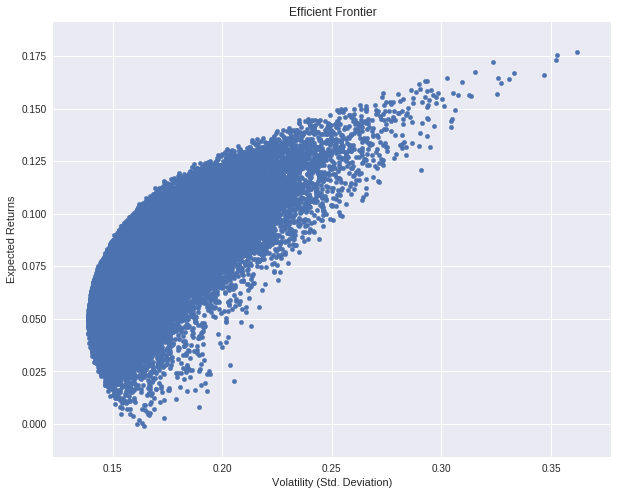

In [45]:
# plot the efficient frontier with a scatter plot
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

50,000 portfolios with different combinations of weights generated different expected returns and expected volatility. Each point lying on the line represents an optimal combination of stocks (CenterPoint Energy, Facebook, Walmart, General Electric, Tesla in this case) that maximises the expected return for the given level of risk. If all points on the Efficient Frontier curve are optimal combinations, what is the optimal portfolio among the various optimal combinations? What would even the criteria for choosing this “best of the best” combinations?

William F. Sharpe, another Nobel Prize laureate extended Markowitz’s work.
We will utilize one of his contributions (the Sharpe Ratio) as criteria for choosing this “best combination”.

<img src="../graphics/Sharpe_ratio.jpg">

Sharpe ratio is simply as a measure of the performance of an investment’s returns given its risk. This ratio adjusts the returns of an investment which makes it possible to compare different investments on a scale that incorporates risk. Without this scale of comparison, it would be virtually impossible to compare different investments with different combinations and their accompanying risks and returns.

We already have expected returns and returns of our simulated portfolios. We are simply going to calculate their risk-adjusted returns (with the help of the Sharpe Ratio), and make a colour bar of the plots using the Sharpe Ratio as the colour map:

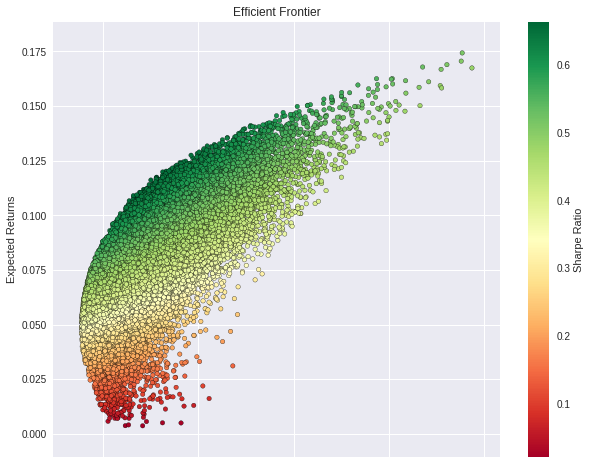

In [46]:
# import needed modules
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# get adjusted closing prices of 5 selected companies with Quandl
quandl.ApiConfig.api_key = 'Uvc7KJzykfvBLjVkNDy2'
selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2016-12-31' }, paginate=True)

# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

# calculate daily and annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

Next up, let’s try to locate the optimal portfolio and another portfolio with the minimum volatility for the most risk-averse investor out there:

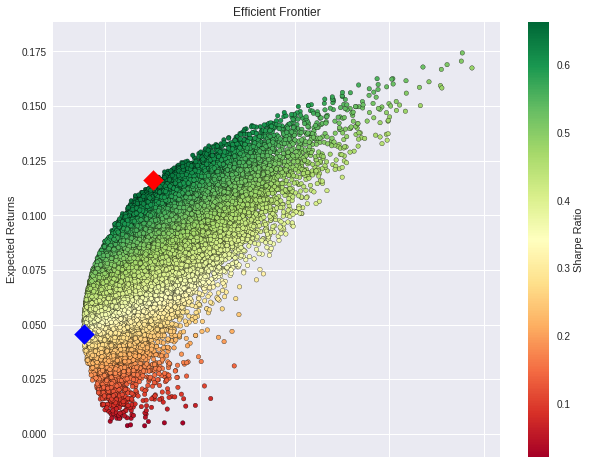

In [47]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
To get specific details of these two special portfolios, let’s print their values out:

In [48]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)

                 17879
Returns       0.045828
Volatility    0.138552
Sharpe Ratio  0.330761
CNP Weight    0.240327
F Weight      0.104659
WMT Weight    0.257760
GE Weight     0.001487
TSLA Weight   0.395767
                 31209
Returns       0.116145
Volatility    0.175045
Sharpe Ratio  0.663514
CNP Weight    0.372890
F Weight      0.008482
WMT Weight    0.404987
GE Weight     0.211450
TSLA Weight   0.002190


The most risk-averse investor would construct the minimum variance portfolio which has an expected return of 4.58% with an accompanying expected volatility of 13.86%. Investors seeking the maximum risk-adjusted return would opt for portfolio that with the maximum Sharpe Ratio which has an expected return of 11.61% with expected volatility pegged at 17.50%